# 1D PDE: SIS diffusion model

[Source](https://docs.sciml.ai/MethodOfLines/stable/tutorials/sispde/)

$$
\begin{align}
\frac{\partial S}{\partial t} &= d_S S_{xx} - \beta(x)\frac{SI}{S+I} + \gamma(x)I  \\
\frac{\partial I}{\partial t} &= d_I I_{xx} + \beta(x)\frac{SI}{S+I} - \gamma(x)I
\end{align}
$$

where $x \in (0, 1)$

Solve the steady-state problem $\frac{\partial S}{\partial t} = \frac{\partial I}{\partial t} = 0$

The boundary condition: $\frac{\partial S}{\partial x} = \frac{\partial I}{\partial x} = 0$ for x = 0, 1

The conservative relationship: $\int^{1}_{0} (S(x) + I(x) ) dx = 1$

Notations:

- $x$ : location
- $t$ : time
- $S(x, t)$ : the density of susceptible populations
- $I(x, t)$ : the density of infected populations
- $d_S$ / $d_I$ : the diffusion coefficients for susceptible and infected individuals
- $\beta(x)$ : transmission rates
- $\gamma(x)$ : recovery rates

In [1]:
using OrdinaryDiffEq
using ModelingToolkit
using MethodOfLines
using DomainSets
using Plots

Setup parameters, variables, and differential operators

In [2]:
@parameters t x
@parameters dS dI brn ϵ
@variables S(..) I(..)
Dt = Differential(t)
Dx = Differential(x)
Dxx = Differential(x)^2

Differential(x) ∘ Differential(x)

Helper functions

In [3]:
γ(x) = x + 1
ratio(x, brn, ϵ) = brn + ϵ * sinpi(2x)

ratio (generic function with 1 method)

1D PDE for disease spreading

In [4]:
eqs = [
    Dt(S(t, x)) ~ dS * Dxx(S(t, x)) - ratio(x, brn, ϵ) * γ(x) * S(t, x) * I(t, x) / (S(t, x) + I(t, x)) + γ(x) * I(t, x),
    Dt(I(t, x)) ~ dI * Dxx(I(t, x)) + ratio(x, brn, ϵ) * γ(x) * S(t, x) * I(t, x) / (S(t, x) + I(t, x)) - γ(x) * I(t, x)
]

2-element Vector{Symbolics.Equation}:
 Differential(t)(S(t, x)) ~ (-(1 + x)*S(t, x)*I(t, x)*(brn + sinpi(2x)*ϵ)) / (S(t, x) + I(t, x)) + dS*Differential(x)(Differential(x)(S(t, x))) + (1 + x)*I(t, x)
 Differential(t)(I(t, x)) ~ ((1 + x)*S(t, x)*I(t, x)*(brn + sinpi(2x)*ϵ)) / (S(t, x) + I(t, x)) + dI*Differential(x)(Differential(x)(I(t, x))) - (1 + x)*I(t, x)

Boundary conditions

In [5]:
bcs = [
    S(0, x) ~ 0.9 + 0.1 * sinpi(2x),
    I(0, x) ~ 0.1 + 0.1 * cospi(2x),
    Dx(S(t, 0)) ~ 0.0,
    Dx(S(t, 1)) ~ 0.0,
    Dx(I(t, 0)) ~ 0.0,
    Dx(I(t, 1)) ~ 0.0
]

6-element Vector{Symbolics.Equation}:
 S(0, x) ~ 0.9 + 0.1sinpi(2x)
 I(0, x) ~ 0.1 + 0.1cospi(2x)
 Differential(x)(S(t, 0)) ~ 0.0
 Differential(x)(S(t, 1)) ~ 0.0
 Differential(x)(I(t, 0)) ~ 0.0
 Differential(x)(I(t, 1)) ~ 0.0

Space and time domains

In [6]:
domains = [
    t ∈ Interval(0.0, 10.0),
    x ∈ Interval(0.0, 1.0)
]

2-element Vector{Symbolics.VarDomainPairing}:
 Symbolics.VarDomainPairing(t, 0.0 .. 10.0)
 Symbolics.VarDomainPairing(x, 0.0 .. 1.0)

Build the PDE system

In [7]:
@named pdesys = PDESystem(eqs, bcs, domains,
    [t, x], ## Independent variables
    [S(t, x), I(t, x)],  ## Dependent variables
    [dS, dI, brn, ϵ],    ## parameters
    defaults = Dict(dS => 0.5, dI => 0.1, brn => 3, ϵ => 0.1)
)

PDESystem
Equations: Symbolics.Equation[Differential(t)(S(t, x)) ~ (-(1 + x)*S(t, x)*I(t, x)*(brn + sinpi(2x)*ϵ)) / (S(t, x) + I(t, x)) + dS*Differential(x)(Differential(x)(S(t, x))) + (1 + x)*I(t, x), Differential(t)(I(t, x)) ~ ((1 + x)*S(t, x)*I(t, x)*(brn + sinpi(2x)*ϵ)) / (S(t, x) + I(t, x)) + dI*Differential(x)(Differential(x)(I(t, x))) - (1 + x)*I(t, x)]
Boundary Conditions: Symbolics.Equation[S(0, x) ~ 0.9 + 0.1sinpi(2x), I(0, x) ~ 0.1 + 0.1cospi(2x), Differential(x)(S(t, 0)) ~ 0.0, Differential(x)(S(t, 1)) ~ 0.0, Differential(x)(I(t, 0)) ~ 0.0, Differential(x)(I(t, 1)) ~ 0.0]
Domain: Symbolics.VarDomainPairing[Symbolics.VarDomainPairing(t, 0.0 .. 10.0), Symbolics.VarDomainPairing(x, 0.0 .. 1.0)]
Dependent Variables: Symbolics.Num[S(t, x), I(t, x)]
Independent Variables: Symbolics.Num[t, x]
Parameters: Symbolics.Num[dS, dI, brn, ϵ]
Default Parameter ValuesDict{Symbolics.Num, Real}(dI => 0.1, ϵ => 0.1, dS => 0.5, brn => 3)

Finite difference method (FDM) converts the PDE system into an ODE problem

In [8]:
dx = 0.01
order = 2
discretization = MOLFiniteDifference([x => dx], t, approx_order=order)
prob = discretize(pdesys, discretization)

ODEProblem with uType Vector{Float64} and tType Float64. In-place: true
Non-trivial mass matrix: false
timespan: (0.0, 10.0)
u0: 198-element Vector{Float64}:
 0.19980267284282716
 0.1992114701314478
 0.19822872507286887
 0.1968583161128631
 0.19510565162951538
 0.19297764858882513
 0.190482705246602
 0.18763066800438638
 0.18443279255020154
 0.18090169943749476
 ⋮
 0.9535826794978997
 0.9481753674101716
 0.9425779291565073
 0.9368124552684678
 0.9309016994374948
 0.9248689887164855
 0.9187381314585725
 0.9125333233564304
 0.9062790519529313

## Solving time-dependent SIS epidemic model
`KenCarp4` is good at solving semilinear problems (like reaction-diffusion problems).

In [9]:
sol = solve(prob, KenCarp4(), saveat=0.2)

retcode: Success
Interpolation: Dict{Symbolics.Num, Interpolations.GriddedInterpolation{Float64, 2, Matrix{Float64}, Interpolations.Gridded{Interpolations.Linear{Interpolations.Throw{Interpolations.OnGrid}}}, Tuple{Vector{Float64}, Vector{Float64}}}}
t: 51-element Vector{Float64}:
  0.0
  0.2
  0.4
  0.6
  0.8
  1.0
  1.2
  1.4
  1.6
  1.8
  ⋮
  8.4
  8.6
  8.8
  9.0
  9.2
  9.4
  9.6
  9.8
 10.0ivs: 2-element Vector{SymbolicUtils.BasicSymbolic{Real}}:
 t
 xdomain:([0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8  …  8.2, 8.4, 8.6, 8.8, 9.0, 9.2, 9.4, 9.6, 9.8, 10.0], 0.0:0.01:1.0)
u: Dict{Symbolics.Num, Matrix{Float64}} with 2 entries:
  S(t, x) => [0.904194 0.906279 … 0.893721 0.895806; 0.879603 0.879585 … 0.7899…
  I(t, x) => [0.2 0.199803 … 0.199803 0.2; 0.204066 0.20397 … 0.245398 0.245559…

Grid points

In [10]:
discrete_x = sol[x]
discrete_t = sol[t]

51-element Vector{Float64}:
  0.0
  0.2
  0.4
  0.6
  0.8
  1.0
  1.2
  1.4
  1.6
  1.8
  ⋮
  8.4
  8.6
  8.8
  9.0
  9.2
  9.4
  9.6
  9.8
 10.0

Results (Matrices)

In [11]:
S_solution = sol[S(t, x)]
I_solution = sol[I(t, x)]

51×101 Matrix{Float64}:
 0.2       0.199803  0.199211  0.198229  …  0.199211  0.199803  0.2
 0.204066  0.20397   0.203684  0.203205     0.244914  0.245398  0.245559
 0.239603  0.239568  0.239463  0.239285     0.320347  0.320719  0.320844
 0.300269  0.300279  0.300309  0.300355     0.413565  0.413853  0.413949
 0.37595   0.375987  0.376098  0.376278     0.503721  0.503946  0.504021
 0.451583  0.451629  0.451768  0.451996  …  0.573511  0.573687  0.573745
 0.516804  0.516848  0.516981  0.517198     0.620077  0.620214  0.62026
 0.566319  0.566357  0.566469  0.566653     0.646894  0.647002  0.647038
 0.601149  0.601179  0.601268  0.601415     0.660188  0.660274  0.660303
 0.624958  0.624981  0.625051  0.625165     0.665471  0.665541  0.665564
 ⋮                                       ⋱                      ⋮
 0.676304  0.676307  0.676318  0.676335     0.656519  0.656544  0.656553
 0.676303  0.676307  0.676318  0.676335     0.656519  0.656544  0.656553
 0.676303  0.676307  0.676317  0.676334 

Visualize the solution

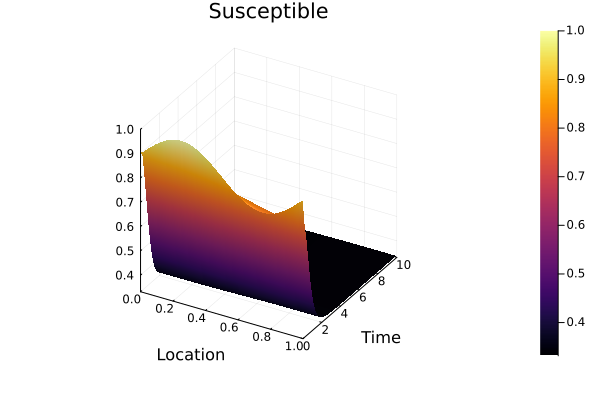

In [12]:
surface(discrete_x, discrete_t, S_solution, xlabel="Location", ylabel="Time", title="Susceptible")

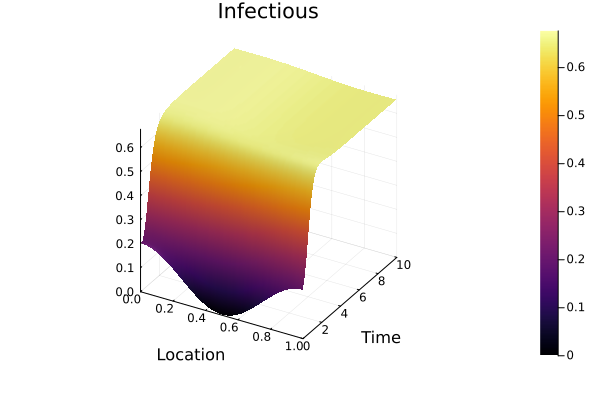

In [13]:
surface(discrete_x, discrete_t, I_solution, xlabel="Location", ylabel="Time", title="Infectious")

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*